In [ ]:
#trabajaremos con datos espaciales instalamos geopandas
!pip install geopandas

In [ ]:
# importamos las librerias que usaremos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt #para graficar
import sklearn
from sklearn.impute import KNNImputer #para realizar la imputacion de valores por knn
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os #para conectarse a la API de Kaggle
import missingno as msno # librería para tratamiento de datos perdidos


# Primer archivo: contiene caracteristicas demograficas por radio censal en CABA

In [ ]:
!wget https://cdn.buenosaires.gob.ar/datosabiertos/datasets/direccion-general-de-estadisticas-y-censos/informacion-censal-por-radio/informacion-censal-por-radio-2010.zip

--2023-09-11 12:48:30--  https://cdn.buenosaires.gob.ar/datosabiertos/datasets/direccion-general-de-estadisticas-y-censos/informacion-censal-por-radio/informacion-censal-por-radio-2010.zip
Resolving cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)... 200.16.89.97
Connecting to cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)|200.16.89.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2426003 (2.3M) [application/zip]
Saving to: ‘informacion-censal-por-radio-2010.zip’

informacion-censal- 100%[===================>]   2.31M   432KB/s    in 5.5s    

2023-09-11 12:48:36 (432 KB/s) - ‘informacion-censal-por-radio-2010.zip’ saved [2426003/2426003]



In [ ]:
#descomprimimos el archivo
! unzip //content/informacion-censal-por-radio-2010.zip

Archive:  //content/informacion-censal-por-radio-2010.zip
  inflating: informacion_censal_por_radio_2010_wgs84.shp.xml  
  inflating: informacion_censal_por_radio_2010_wgs84.shx  
  inflating: informacion_censal_por_radio_2010_wgs84.cpg  
  inflating: informacion_censal_por_radio_2010_wgs84.csv  
  inflating: informacion_censal_por_radio_2010_wgs84.dbf  
  inflating: informacion_censal_por_radio_2010_wgs84.geojson  
  inflating: informacion_censal_por_radio_2010_wgs84.prj  
  inflating: informacion_censal_por_radio_2010_wgs84.shp  


In [ ]:
shapefile = gpd.read_file("/content/informacion_censal_por_radio_2010_wgs84.shp")

## Se calcula el centroide por radio censal

In [ ]:
#calculamos el centroide de cada radio censal como campo en un geodataframe y guardamos los datos en una nueva variable
shapefile["centroide"] = shapefile.geometry.centroid

<ipython-input-6-5d6c70d1e198>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile["centroide"] = shapefile.geometry.centroid


In [ ]:
# Convertimos el GeoDataFrame a DataFrame de pandas
df_censo = pd.DataFrame(shapefile)

# Segundo archivo: caracteristicas de propiedades a la venta

Este dataframe contiene el indice y 24 columnas:
1) ad_type,
2) start_date: fecha de alta del aviso,
3) end_date:fecha de baja del aviso,
4) created_on:fecha de creacion,
5) lat:latitud (junto con longitud son las coordenadas geograficas para identificar la ubicacion de la propiedad),
6) lon: longitud,
7) l1:nivel administrativo1 (usualmente pais),
8) l2:nivel administrativo 2 (usualmente provincia),
9) l3:nivel administrativo 3 (usualmente ciudad),
10) l4:nivel administrativo 4,
11) l5:nivel administrativo 5,
12) l6: nivel administrativo 6,
13)rooms: cantidad de ambientes,
14) bedrooms: cantidad de dormitorios,
15) surface_total: superficie total,
16) surface_covered: superficie cubierta,
17) price:precio,
18) currency:moneda en la que esta expresada el precio,
19) price_period:periodo temporal en que esta fijado el precio (mes, año, precio de venta),
20) title: titulo del aviso,
21) description:descripcion del aviso,
22) property_type: tipo de propiedad (departamento, casa, PH),
23) operation_type: tipo de operacion (venta, alquiler).

In [ ]:
#Coneccion a la API de Kaggle con nombre de usuario y clave

os.environ['KAGGLE_USERNAME'] = "leomartinelli"
os.environ['KAGGLE_KEY'] = "9390a9b784b3b9a66095f572a564597e"

In [ ]:
#se importa el archivo de datos comprimido desde Kaggle
!kaggle datasets download -d msorondo/argentina-venta-de-propiedades

100% 703M/703M [00:13<00:00, 52.8MB/s]
100% 703M/703M [00:13<00:00, 55.7MB/s]


In [ ]:
#se descomprimen los archivos
!unzip /content/argentina-venta-de-propiedades.zip

Archive:  /content/argentina-venta-de-propiedades.zip
  inflating: ar_properties.csv       
  inflating: ar_properties_crude.csv  
  inflating: co_properties_crude.csv  
  inflating: ec_properties_crude.csv  
  inflating: pe_properties_crude.csv  
  inflating: uy_properties_crude.csv  


In [ ]:
#Se crea un pandas dataframe con los datos de las propiedades en venta
df_propiedades = pd.read_csv("/content/ar_properties_crude.csv", index_col="id")

In [ ]:
#Nos interesan las propiedades a la venta que esten en Argentina, Capital Federal y con los precios expresados en dolares
df_caba = df_propiedades[(df_propiedades["l1"]=="Argentina") & (df_propiedades["l2"]=="Capital Federal") & (df_propiedades["currency"]=="USD") & (df_propiedades["operation_type"]=="Venta")]

In [ ]:
#se renombran las columnas del df de propiedades de CABA en venta en dolares con denominaciones mas claras

# Se obtienen los nombres de las columnas actuales
nombres_actuales = df_caba.columns.tolist()

# Se definen los nuevos nombres de las columnas
nombres_nuevos =['tipo_aviso', 'fecha_alta', 'fecha_baja', 'fecha_creacion', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'n_ambientes', 'n_dormitorios', 'n_baños',
       'superficie_total', 'superficie_cubierta', 'precio', 'moneda', 'precio_periodo',
       'titulo_aviso', 'descripcion', 'tipo_propiedad', 'tipo_operacion']

# Se asignan los nuevos nombres de las columnas al DataFrame
df_caba.columns = nombres_nuevos

In [ ]:
#cambiamos el indice del dataframe por uno numerico secuencial en una columna de nombre id
df_caba.reset_index(inplace=True)
df_caba.drop("id", axis=1, inplace=True)

<ipython-input-14-055d260ac2c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caba.drop("id", axis=1, inplace=True)


In [ ]:
#eliminamos las columnas que no tienen informacion relevante o que estan completamente vacias

df_caba = df_caba.drop(columns=['tipo_aviso','l1', 'l2','l4','l5','l6','moneda', 'precio_periodo','titulo_aviso','descripcion','tipo_operacion'])

#dado que vamos a predecir el precio de la propiedad en funcion de indicadores de preferencia de los clientes eliminamos los campos
#fecha_alta, fecha_baja y fecha_creacion. Ademas renombramos al campo l3 como barrio.

# Eliminamos las columnas "fecha_alta", "fecha_baja" y "fecha_creacion"
df_caba.drop(["fecha_alta", "fecha_baja", "fecha_creacion"], axis=1, inplace=True)

# Renombrar la columna "l3" como "barrio"
df_caba.rename(columns={"l3": "barrio"}, inplace=True)


In [ ]:
#Filtramos los departamentos que es el tipo de propiedad que nos interesa en este trabajo
df_caba_dto = df_caba[df_caba['tipo_propiedad'] == 'Departamento']

In [ ]:
# Como necesitamos la posicion de la propiedad para este trabajo eliminamos los registros que no tengan la posicion de la propiedad definida
#Es decir eliminamos los registros donde lat o lon no esten definidos o sean nulas
df_caba_dto = df_caba_dto.dropna(subset=['lat'], thresh=1)
df_caba_dto = df_caba_dto.dropna(subset=['lon'], thresh=1)

In [ ]:
#Nos interesa modelar para departamentos de 1 a 6 ambientes
#precios entre 15000 y 500000 u$s
#1 a 6 ambientes
#superficie total de 15 a 500 m2
df_caba_dto = df_caba_dto[
    (df_caba_dto['n_ambientes'].between(1, 8)) &
    (df_caba_dto['superficie_total'].between(15, 500)) &
    (df_caba_dto['precio'].between(15000, 500000))
]

Creamos un campo geometry con el cual operaremos para unirlo la dataframe de datos censales

In [ ]:
# Convertimos latitud y longitud de la base de propiedades en puntos geométricos
geometry = gpd.points_from_xy(df_caba_dto['lon'], df_caba_dto['lat'])

# Crear un GeoDataFrame con la columna de geometría y conservar los otros campos
gdf_caba = gpd.GeoDataFrame(df_caba_dto).assign(geometry=geometry)

# Creamos un nuevo DataFrame a partir del GeoDataFrame
df_caba_dto = pd.DataFrame(gdf_caba)

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4889: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


# Construccion del dataframe que contiene los datos de trabajo

In [ ]:
#Armamos un dataframe que resulta de unir cada registro de df_caba_dto
#a traves del campo df_caba_dto['geometry'] con  vecino mas cercano del dataframe df en el campo df['centroide']
#trabajamos con datos espaciales

# Convertimos el campo "geometry" de df_caba_dto en objetos Point
df_caba_dto['geometry'] = df_caba_dto['geometry'].apply(Point)

# Convertimos el campo "centroide" de df en objetos Point
df_censo['centroide'] = df_censo['centroide'].apply(Point)

# Obtenemos las coordenadas (x, y) de los puntos en df['centroide']
centroide_coords = df_censo['centroide'].apply(lambda p: (p.x, p.y)).tolist()

# Creamos un cKDTree con las coordenadas de los puntos en df['centroide']
tree = cKDTree(centroide_coords)

# Obtenemos las coordenadas (x, y) de los puntos en df_caba_dto['geometry']
caba_coords = df_caba_dto['geometry'].apply(lambda p: (p.x, p.y)).tolist()

# Encontramos el índice del vecino más cercano para cada punto en df_caba_dto['geometry']
distances, indices = tree.query(caba_coords)

# Agregamos una columna 'nearest_centroide' al DataFrame df_caba_dto
df_caba_dto['nearest_centroide'] = df_censo['centroide'].iloc[indices].values

# Realizamos una fusión entre df_caba_dto y df basada en la columna 'nearest_centroide'
df_union = pd.merge(df_caba_dto, df_censo, left_on='nearest_centroide', right_on='centroide', suffixes=('_caba', '_df'))

In [ ]:
df_union.columns

Index(['lat', 'lon', 'barrio', 'n_ambientes', 'n_dormitorios', 'n_baños',
       'superficie_total', 'superficie_cubierta', 'precio', 'tipo_propiedad',
       'geometry_caba', 'nearest_centroide', 'ID', 'CO_FRAC_RA', 'COMUNA',
       'FRACCION', 'RADIO', 'TOTAL_POB', 'T_VARON', 'T_MUJER', 'T_VIVIENDA',
       'V_PARTICUL', 'V_COLECTIV', 'T_HOGAR', 'H_CON_NBI', 'H_SIN_NBI',
       'geometry_df', 'centroide'],
      dtype='object')

In [ ]:
columnas_trabajo=['barrio','n_ambientes','superficie_total', 'superficie_cubierta',
                  'precio','nearest_centroide','FRACCION', 'RADIO', 'TOTAL_POB', 'T_VIVIENDA',
                  'V_PARTICUL','T_HOGAR', 'H_CON_NBI']

df_trabajo=df_union[columnas_trabajo]

#Tratamiento de datos faltantes e ingenieria de atributos

In [ ]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71120 entries, 0 to 71119
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   barrio               71034 non-null  object 
 1   n_ambientes          71120 non-null  float64
 2   superficie_total     71120 non-null  float64
 3   superficie_cubierta  69397 non-null  float64
 4   precio               71120 non-null  float64
 5   nearest_centroide    71120 non-null  object 
 6   FRACCION             71120 non-null  int64  
 7   RADIO                71120 non-null  int64  
 8   TOTAL_POB            71120 non-null  int64  
 9   T_VIVIENDA           71120 non-null  float64
 10  V_PARTICUL           71120 non-null  int64  
 11  T_HOGAR              71120 non-null  float64
 12  H_CON_NBI            71120 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 7.6+ MB


<Axes: >

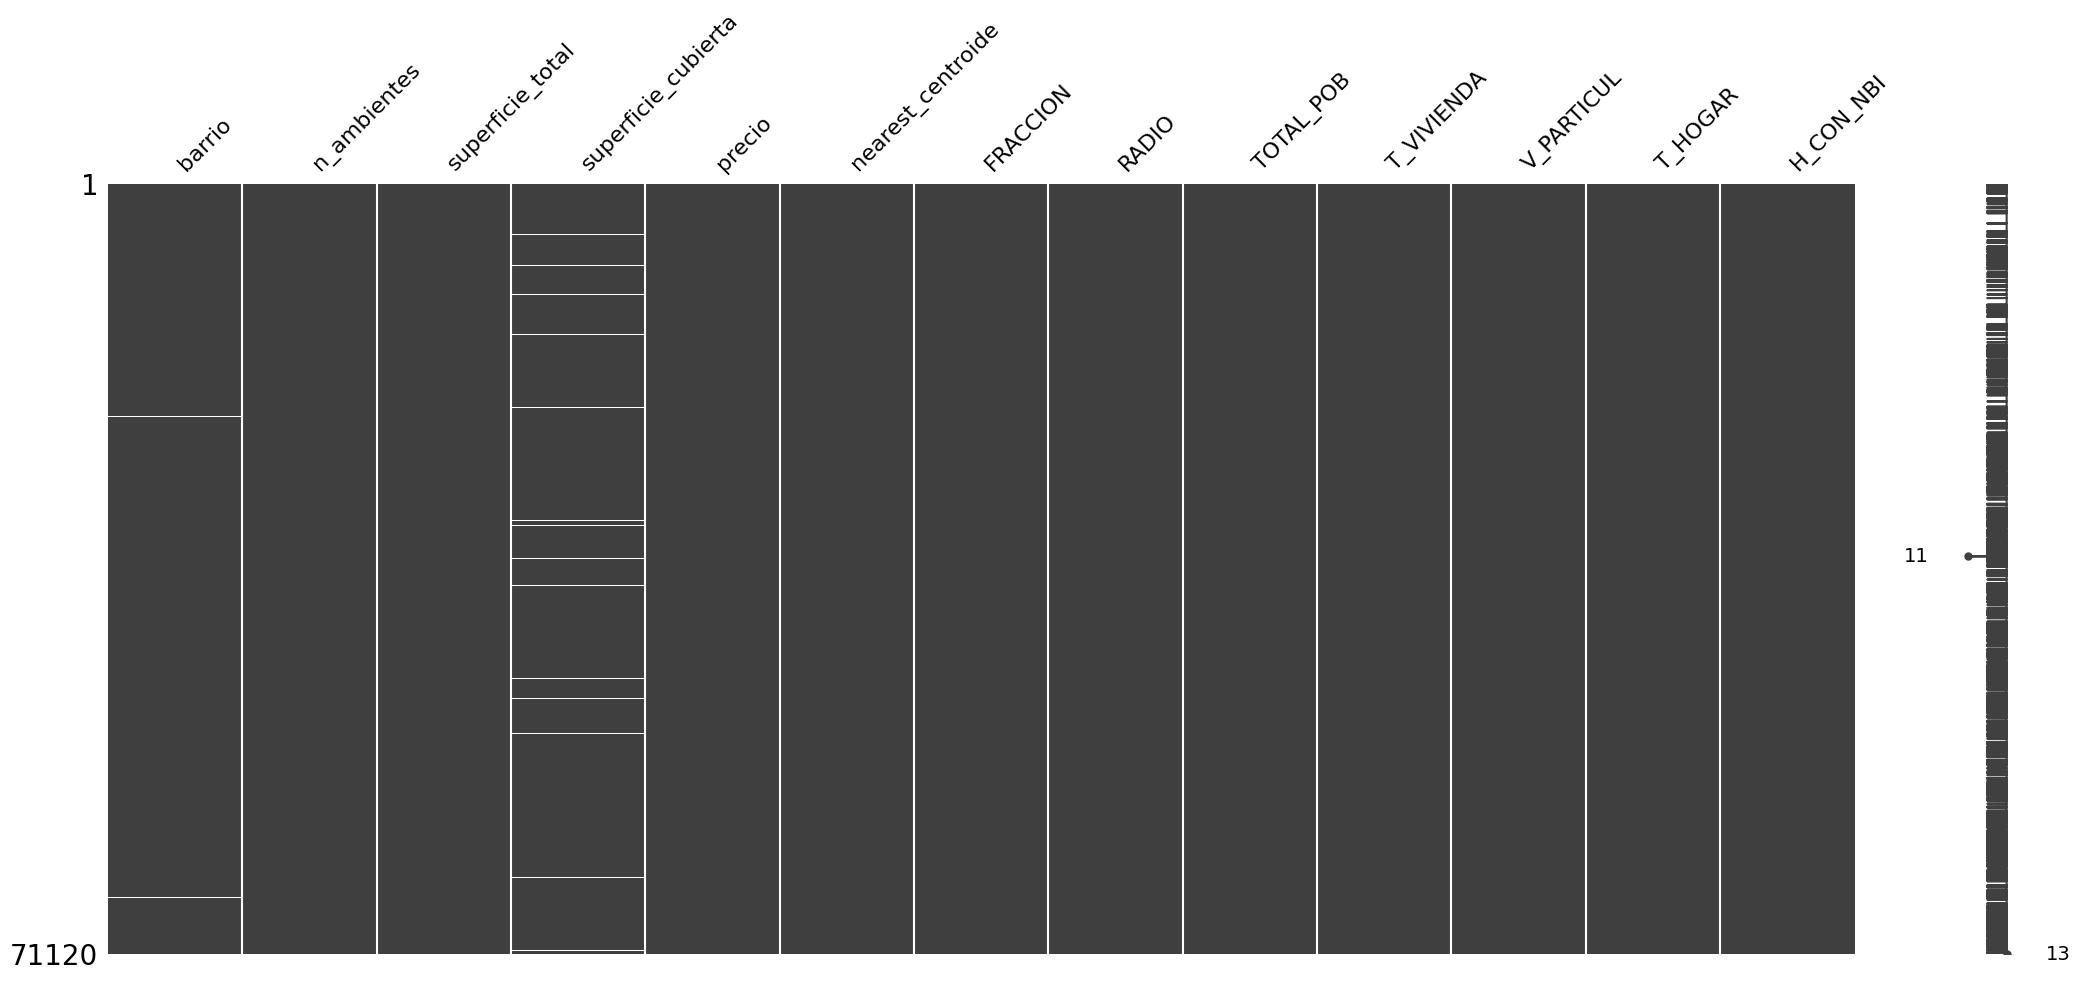

In [ ]:
msno.matrix(df_trabajo)

## Variable superficie_cubierta

In [ ]:
#contamos registros sin valor de superficie_cubierta
contador_cub_na = df_caba[df_caba['superficie_cubierta'].isnull()].shape[0]
contador_cub_na

68624

In [ ]:
# A los registros que tienen datos faltantes de superficie cubierta y definida la superficie total les asignaremos la superficie total
# Verificar si la superficie_cubierta es nula y la superficie_total tiene un valor
condicion = df_trabajo['superficie_cubierta'].isnull() & df_trabajo['superficie_total'].notnull()

# Asignar el valor de superficie_total a superficie_cubierta donde se cumpla la condición
df_trabajo.loc[condicion, 'superficie_cubierta'] = df_trabajo.loc[condicion, 'superficie_total']

In [ ]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71120 entries, 0 to 71119
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   barrio               71034 non-null  object 
 1   n_ambientes          71120 non-null  float64
 2   superficie_total     71120 non-null  float64
 3   superficie_cubierta  71120 non-null  float64
 4   precio               71120 non-null  float64
 5   nearest_centroide    71120 non-null  object 
 6   FRACCION             71120 non-null  int64  
 7   RADIO                71120 non-null  int64  
 8   TOTAL_POB            71120 non-null  int64  
 9   T_VIVIENDA           71120 non-null  float64
 10  V_PARTICUL           71120 non-null  int64  
 11  T_HOGAR              71120 non-null  float64
 12  H_CON_NBI            71120 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 7.6+ MB


## Creacion variable porcentaje de hogares con NBI y extraccion de los campos para armar el modelo

Creamos la variable %HogarNBI como el porcentaje de la cantidad de hogares que tienen necesidades basicas insatisfechas dividido el total de hogares en el radio censal donde se encuentra la propiedad

In [ ]:
df_trabajo['%HogarNBI'] = (df_trabajo['H_CON_NBI'] / df_trabajo['T_HOGAR']) * 100

<ipython-input-28-6c3a0fdbdb21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trabajo['%HogarNBI'] = (df_trabajo['H_CON_NBI'] / df_trabajo['T_HOGAR']) * 100


In [ ]:
columnas_lista = df_trabajo.columns.tolist()

In [ ]:
columnas_lista

['barrio',
 'n_ambientes',
 'superficie_total',
 'superficie_cubierta',
 'precio',
 'nearest_centroide',
 'FRACCION',
 'RADIO',
 'TOTAL_POB',
 'T_VIVIENDA',
 'V_PARTICUL',
 'T_HOGAR',
 'H_CON_NBI',
 '%HogarNBI']

In [ ]:
#Creamos el dataframe que utilizaremos en el modelo y a la variable superficie_total la renombramos como sup_propiedad
df_modelo = df_trabajo.loc[:, ['precio', 'n_ambientes', 'superficie_total', '%HogarNBI']].copy()
df_modelo.rename(columns={'superficie_total': 'sup_propiedad'}, inplace=True)

In [ ]:
df_modelo

,precio,n_ambientes,sup_propiedad,%HogarNBI
0,95000.0,3.0,63.0,1.442308
1,135000.0,3.0,58.0,1.442308
2,65000.0,1.0,23.0,1.442308
3,85000.0,1.0,36.0,1.442308
4,145000.0,3.0,59.0,1.442308
...,...,...,...,...
71115,65000.0,2.0,58.0,40.087146
71116,53000.0,1.0,30.0,5.263158
71117,82000.0,1.0,29.0,0.000000
71118,78900.0,2.0,41.0,3.153153


In [ ]:
#eliminamos las filas donde %HogarNBI es nulo
df_modelo = df_modelo.dropna(subset=['%HogarNBI'])

# Analisis descriptivo

<Axes: >

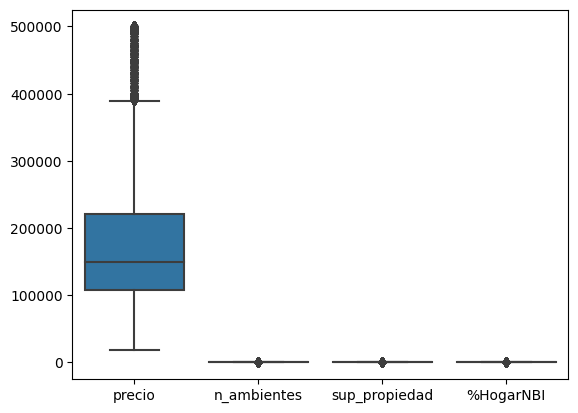

In [ ]:
# Visualizar el boxplot
sns.boxplot(data=df_modelo)

<Axes: >

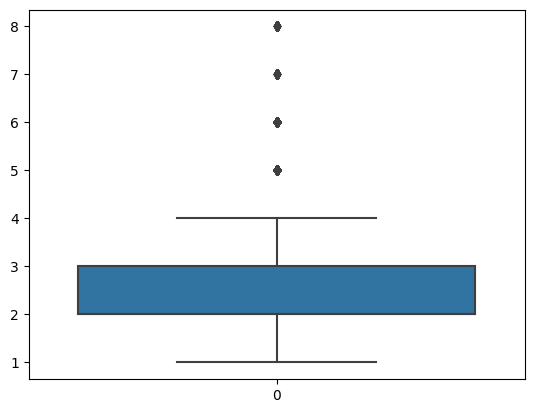

In [ ]:
sns.boxplot(data=df_modelo['n_ambientes'])

In [ ]:
df_modelo.to_csv('df_modelo2.csv', index=False)

In [ ]:
#Hallamos los estadisticos descriptivos
pp=df_modelo.describe()

In [ ]:
pp.to_excel('pp.xlsx')

<Axes: ylabel='n_ambientes'>

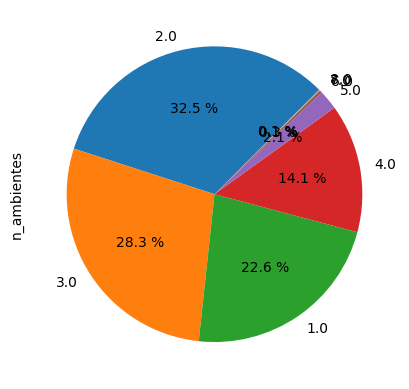

In [ ]:
# Gráfico de torta
df_modelo['n_ambientes'].value_counts().plot.pie(startangle=45,autopct='%.1f %%')

<ipython-input-40-91656ddd8393>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_modelo['%HogarNBI'])


<Axes: xlabel='%HogarNBI', ylabel='Density'>

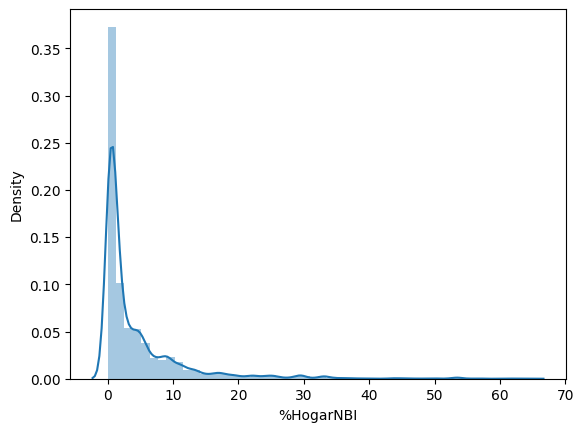

In [ ]:
# distribución de la variable %nbi
sns.distplot(df_modelo['%HogarNBI'])

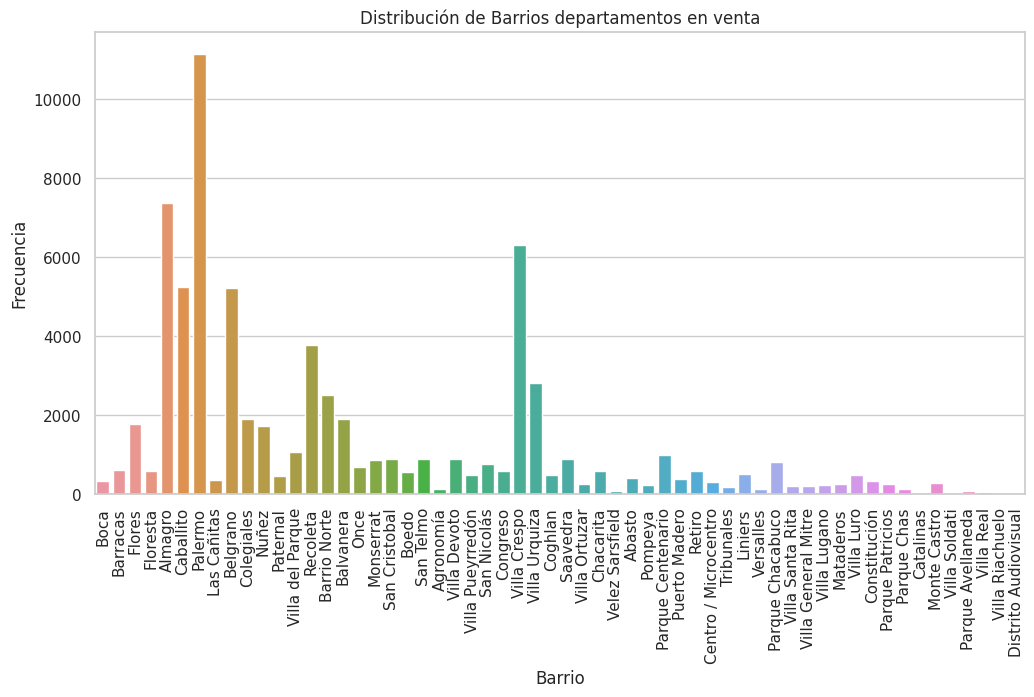

In [ ]:
df_modelo2 = df_modelo.merge(df_trabajo[['barrio']], left_index=True, right_index=True, how='left')

sns.set(style="whitegrid")  # Establecer el estilo del gráfico
plt.figure(figsize=(12, 6))  # Establecer el tamaño de la figura

# Graficamos el gráfico de barras
sns.countplot(data=df_modelo2, x='barrio')

# Establecemos los títulos y etiquetas de los ejes
plt.title("Distribución de Barrios departamentos en venta")
plt.xlabel("Barrio")
plt.ylabel("Frecuencia")

# Rotamos las etiquetas del eje x
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Hallamos la matriz de correlaciones
correlaciones = df_modelo.corr()
print(correlaciones)

                 precio  n_ambientes  sup_propiedad  %HogarNBI
precio         1.000000     0.639515       0.777792  -0.162055
n_ambientes    0.639515     1.000000       0.740281  -0.041238
sup_propiedad  0.777792     0.740281       1.000000  -0.047351
%HogarNBI     -0.162055    -0.041238      -0.047351   1.000000


<ipython-input-43-68b7dc62cd08>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_modelo2.corr()


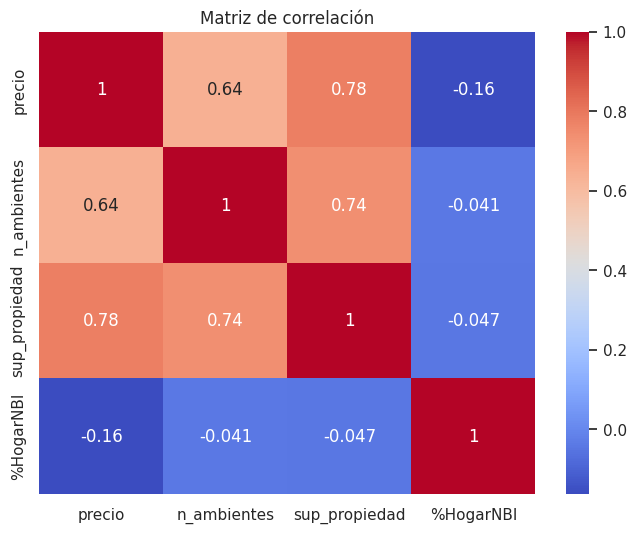

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df_modelo2.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Establecer el título del gráfico
plt.title('Matriz de correlación')

# Mostrar el gráfico
plt.show()

# Aplicacion de modelos

In [ ]:
import statsmodels.api as sm #Nos permite acceder al conjunto de datos y realizar regresión lineal
from sklearn.tree import DecisionTreeRegressor #árboles de regresión
from sklearn.ensemble import RandomForestRegressor #Random forrest para regresion
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error,mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Columnas de df_modelo
columnas = df_modelo.columns
print(columnas)

Index(['precio', 'n_ambientes', 'sup_propiedad', '%HogarNBI'], dtype='object')


In [ ]:
# Separamos las variables predictoras (X) y la variable objetivo (y)
X = df_modelo.drop('precio', axis=1)
y = df_modelo['precio']

In [ ]:
# Crear un objeto Scaler
scaler = StandardScaler()

# Escalar las variables independientes (X) y la variable dependiente (y)
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.reshape(y.values, (-1, 1)))

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=123)


## Regresion lineal multiple

In [ ]:
pip install mlxtend

In [ ]:
pip install --upgrade mlxtend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS #SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.preprocessing import scale

In [ ]:
#Planteamos la regresión con las 3 variables explicativas
#Vemos por el valor alto de numero de condicion y por la matriz de correlacion que hay colinealidad
#entre variables como el numero de ambientes y la superficie de la propiedad
#un modelo de RGL con todas las variables es inadecuado. Probamos mas modelos donde no esten juntas ambientes y superficie

# Realizar validación cruzada con k=5
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# Listas para almacenar los resultados de cada fold
scores_mse = []
scores_r2 = []

# Iterar sobre los folds de la validación cruzada
for train_index, val_index in kf.split(X_scaled):
    # Dividir los datos en conjuntos de entrenamiento y validación para cada fold
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]

    # Ajustar el modelo de regresión lineal con OLS en el conjunto de entrenamiento
    ModeloRGL1 = sm.OLS(y_train, sm.add_constant(X_train))
    modelo_fit = ModeloRGL1.fit()

    # Evaluar el modelo en el conjunto de validación
    y_pred = modelo_fit.predict(sm.add_constant(X_val))
    mse = np.mean((y_val - y_pred)**2)
    r2 = modelo_fit.rsquared
    scores_mse.append(mse)
    scores_r2.append(r2)

# Calcular el promedio de los puntajes
mean_mse = np.mean(scores_mse)
mean_r2 = np.mean(scores_r2)

# Imprimir el resumen del modelo
print(modelo_fit.summary())
print("Mean Squared Error:", mean_mse)
print("Mean R^2:", mean_r2)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.217e+04
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:50:28   Log-Likelihood:                -52416.
No. Observations:               56818   AIC:                         1.048e+05
Df Residuals:                   56814   BIC:                         1.049e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.528      0.5

In [ ]:
#Planteamos la regresión con las 2 variables explicativas cantidad ambientes y %HogarNBI
# Escalar las variables explicativas
scaler = StandardScaler()
X_scaledRGL2 = scaler.fit_transform(df_modelo2[['n_ambientes', '%HogarNBI']])

# Realizar validación cruzada con k=5
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# Listas para almacenar los resultados de cada fold
scores_mse = []
scores_r2 = []

# Iterar sobre los folds de la validación cruzada
for train_index, val_index in kf.split(X_scaled):
    # Dividir los datos en conjuntos de entrenamiento y validación para cada fold
    X_train, X_val = X_scaledRGL2[train_index], X_scaledRGL2[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]

    # Ajustar el modelo de regresión lineal con OLS en el conjunto de entrenamiento
    ModeloRGL2 = sm.OLS(y_train, sm.add_constant(X_train))
    modelo_fit = ModeloRGL2.fit()

    # Evaluar el modelo en el conjunto de validación
    y_pred = modelo_fit.predict(sm.add_constant(X_val))
    mse = np.mean((y_val - y_pred)**2)
    r2 = modelo_fit.rsquared
    scores_mse.append(mse)
    scores_r2.append(r2)

# Calcular el promedio de los puntajes
mean_mse = np.mean(scores_mse)
mean_r2 = np.mean(scores_r2)

# Imprimir el resumen del modelo
print(modelo_fit.summary())
print("Mean Squared Error:", mean_mse)
print("Mean R^2:", mean_r2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 2.108e+04
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:50:34   Log-Likelihood:                -64854.
No. Observations:               56818   AIC:                         1.297e+05
Df Residuals:                   56815   BIC:                         1.297e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.411      0.6

In [ ]:
#Planteamos la regresión con las 2 variables explicativas sup_propiedad y %HogarNBI
#Este modelo es mejor
# Escalar las variables explicativas
scaler = StandardScaler()
X_scaledRGL3 = scaler.fit_transform(df_modelo2[['sup_propiedad', '%HogarNBI']])

# Realizar validación cruzada con k=5
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# Listas para almacenar los resultados de cada fold
scores_mse = []
scores_r2 = []

# Iterar sobre los folds de la validación cruzada
for train_index, val_index in kf.split(X_scaled):
    # Dividir los datos en conjuntos de entrenamiento y validación para cada fold
    X_train, X_val = X_scaledRGL3[train_index], X_scaledRGL3[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]

    # Ajustar el modelo de regresión lineal con OLS en el conjunto de entrenamiento
    ModeloRGL3_scaled = sm.OLS(y_train, sm.add_constant(X_train))
    modelo_fit = ModeloRGL3_scaled.fit()

    # Evaluar el modelo en el conjunto de validación
    y_pred = modelo_fit.predict(sm.add_constant(X_val))
    mse = np.mean((y_val - y_pred)**2)
    r2 = modelo_fit.rsquared
    scores_mse.append(mse)
    scores_r2.append(r2)

# Calcular el promedio de los puntajes
mean_mse = np.mean(scores_mse)
mean_r2 = np.mean(scores_r2)

# Imprimir el resumen del modelo
print(modelo_fit.summary())
print("Mean Squared Error:", mean_mse)
print("Mean R^2:", mean_r2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 4.663e+04
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:50:40   Log-Likelihood:                -53027.
No. Observations:               56818   AIC:                         1.061e+05
Df Residuals:                   56815   BIC:                         1.061e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.517      0.6

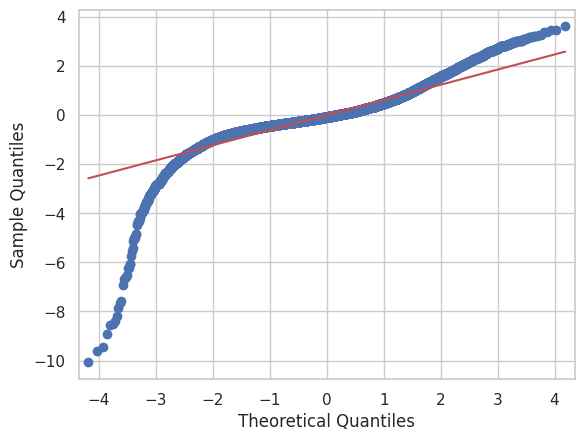

In [ ]:
# Ajustar el modelo de regresión lineal múltiple con las variables escaladas
X_scaledRGL3 = sm.add_constant(X_scaledRGL3)
ModeloRGL3_scaled = sm.OLS(y_scaled, X_scaledRGL3)
modelo_fit = ModeloRGL3_scaled.fit()

# Obtener los residuos del modelo
residuos = modelo_fit.resid

# Generar el gráfico QQ plot
sm.qqplot(residuos, line='s', dist=stats.norm)

# Mostrar el gráfico
plt.show()

In [ ]:
#Test de normalidad de Shapiro Wilks
shapiro(residuos)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8981929421424866, pvalue=0.0)

In [ ]:
# Crear un modelo de regresión lineal
modelo = LinearRegression()

# Selección de características hacia adelante
sfs_forward = SFS(modelo, k_features=(1,3), forward=True, scoring='r2', cv=5)
sfs_forward.fit(X, y)

# Selección de características hacia atrás
sfs_backward = SFS(modelo, k_features=(1,3), forward=False, scoring='r2', cv=5)
sfs_backward.fit(X, y)

# Obtener los índices de características seleccionados para ambos métodos
forward_idx = sfs_forward.k_feature_idx_
backward_idx = sfs_backward.k_feature_idx_

# Obtener los nombres de las características seleccionadas
forward_features = X.columns[list(forward_idx)]
backward_features = X.columns[list(backward_idx)]

print('Características seleccionadas hacia adelante:', forward_features)
print('Características seleccionadas hacia atrás:', backward_features)

Características seleccionadas hacia adelante: Index(['n_ambientes', 'sup_propiedad', '%HogarNBI'], dtype='object')
Características seleccionadas hacia atrás: Index(['n_ambientes', 'sup_propiedad', '%HogarNBI'], dtype='object')


## Arboles de regresion

In [ ]:
# Vamos a trabajar la función DecisionTreeRegressor de la librería sklearn.tree
# Crear modelo de árbol de regresion con profundidad 4, minimo de muestras por hoja 25
# Creamos el modelo de árbol de decisión con todos los parámetros por defecto
Mod1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=25)

# Realizamos la validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scoresMSE = []
scoresMAE = []
scoresr2 = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Entrenamos el modelo en el conjunto de entrenamiento fold
    Mod1.fit(X_train_fold, y_train_fold)

    # Realizamos predicciones en el conjunto de validación fold
    y_pred_fold = Mod1.predict(X_val_fold)

    # Calculamos las métricas para el conjunto de validación
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)

    # Guardamos las métricas en las listas correspondientes
    scoresMSE.append(mse)
    scoresMAE.append(mae)
    scoresr2.append(r2)


# Calcular la puntuación promedio de rendimiento
mean_MSE = np.mean(scoresMSE)
mean_MAE = np.mean(scoresMAE)
mean_r2 = np.mean(scoresr2)
print("Mean MSE:", mean_MSE)
print("Mean MAE:", mean_MAE)
print("Mean R2:", mean_r2)

Mean MSE: 0.3209084208481301
Mean MAE: 0.39964451048147026
Mean R2: 0.6790754629462908


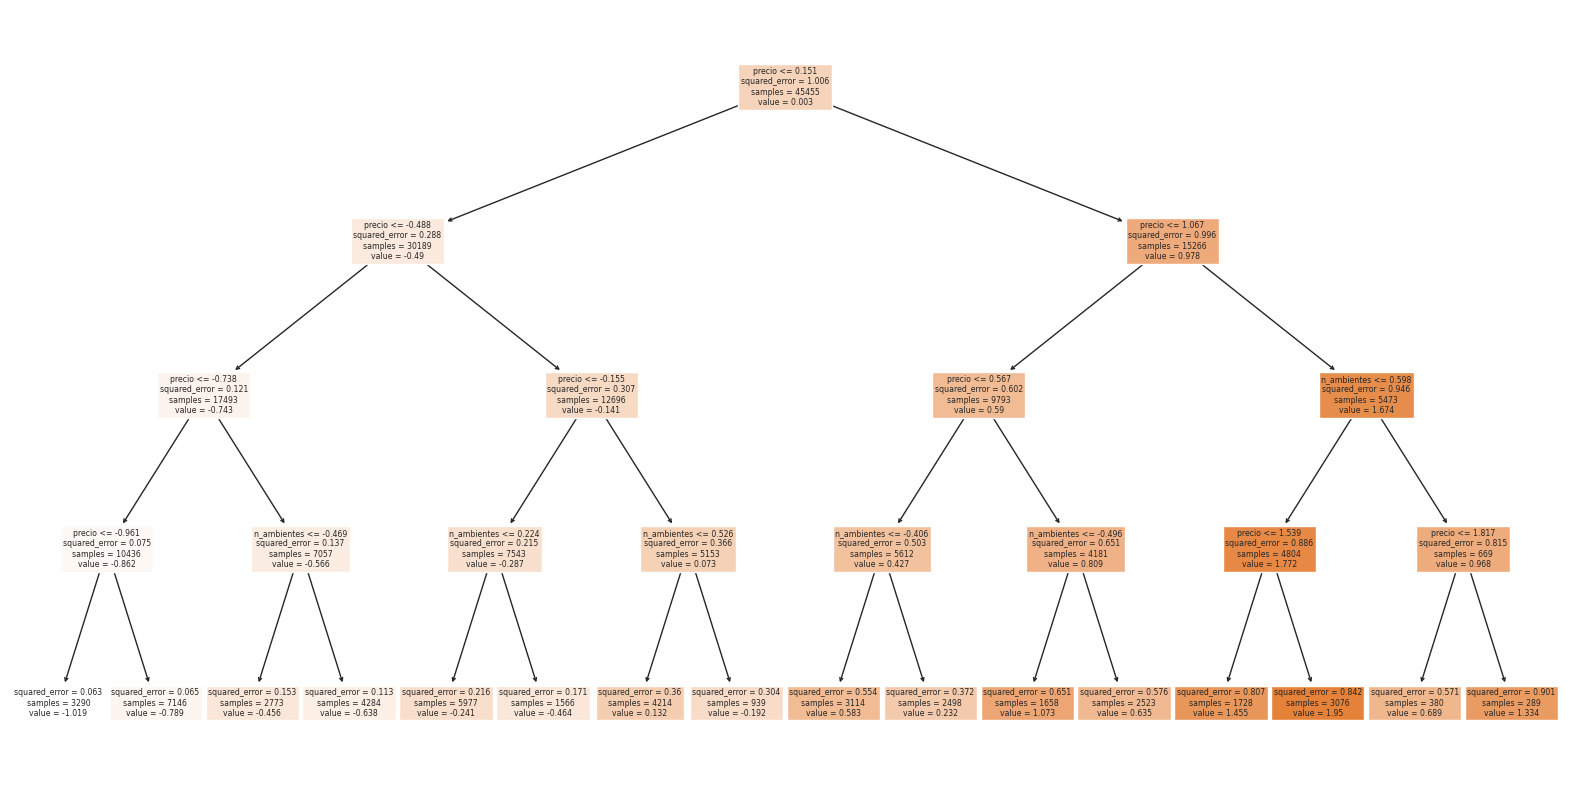

In [ ]:
plt.figure(figsize=(20, 10))
feature_names = df_modelo.columns

# Graficar el árbol de regresión
plot_tree(Mod1, feature_names=feature_names, filled=True)

# Mostrar la figura
plt.show()

###Arboles de regresion con Grid Search

In [ ]:
# Definir los valores posibles para los parámetros del modelo
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [25,50,100,150],
              'min_samples_leaf': [25, 30, 40, 50,100 ]}

# Crear un objeto de árbol de regresión
treereg = DecisionTreeRegressor()

# Crear un objeto GridSearchCV con el modelo y los parámetros
grid_searchMSE = GridSearchCV(treereg, param_grid, cv=5, n_jobs=-1)

# Ajustar el modelo con los datos
grid_searchMSE.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(grid_searchMSE.best_params_)

# Imprimir la mejor puntuación del modelo
print(grid_searchMSE.best_score_)


{'max_depth': 6, 'min_samples_leaf': 100, 'min_samples_split': 25}
0.6661952448026389


Con el mejor modelo obtenido por Grid search calculamos las metricas de evaluacion y aplicamos cross validation

In [ ]:
# Vamos a trabajar la función DecisionTreeRegressor de la librería sklearn.tree
# Crear modelo de árbol de regresion con profundidad 4, minimo de muestras por hoja 25
# Creamos el modelo de árbol de decisión con todos los parámetros por defecto
Mod2 = DecisionTreeRegressor(max_depth=10,min_samples_leaf= 25,min_samples_split=25)

# Realizamos la validación cruzada con StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scoresMSE = []
scoresMAE = []
scoresr2 = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Entrenamos el modelo en el conjunto de entrenamiento fold
    Mod1.fit(X_train_fold, y_train_fold)

    # Realizamos predicciones en el conjunto de validación fold
    y_pred_fold = Mod1.predict(X_val_fold)

    # Calculamos las métricas para el conjunto de validación
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)

    # Guardamos las métricas en las listas correspondientes
    scoresMSE.append(mse)
    scoresMAE.append(mae)
    scoresr2.append(r2)


# Calcular la puntuación promedio de rendimiento
mean_MSE = np.mean(scoresMSE)
mean_MAE = np.mean(scoresMAE)
mean_r2 = np.mean(scoresr2)
print("Mean MSE:", mean_MSE)
print("Mean MAE:", mean_MAE)
print("Mean R2:", mean_r2)

Mean MSE: 0.3209084208481301
Mean MAE: 0.39964451048147015
Mean R2: 0.6790754629462907


##Random Forrest

In [ ]:
# Escalar las variables independientes (X) y la variable dependiente (y)
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.reshape(y.values, (-1, 1)))
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=123)


# Creamos el modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=184)

# Entrenamos el modelo en el conjunto de entrenamiento
rf.fit(X_train, y_train)

# Haciendo predicciones en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluamos el rendimiento del modelo utilizando el error cuadrático medio (MSE), el MAE y el r2
mse = mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("MAE",mae)
print("R2",r2)

<ipython-input-62-6acc2e17fe98>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


MSE: 0.17087885330490576
MAE 0.23444888774654046
R2 0.8268988832194596


In [ ]:
from sklearn.utils import column_or_1d

In [ ]:
#Hacemos cross validation con random forrest

# Convertir y_train a un array unidimensional
y_train = column_or_1d(y_train, warn=True)
#####
rf = RandomForestRegressor(random_state=123)
msescores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
maescores=cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
r2scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')

print("MSE promedio: {:.4f}".format(msescores.mean()))
print("MAE promedio: {:.4f}".format(maescores.mean()))
print("R2 promedio: {:.4f}".format(r2scores.mean()))


<ipython-input-64-f463e4f7d0f4>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_train = column_or_1d(y_train, warn=True)


MSE promedio: -0.1883
MAE promedio: -0.2471
R2 promedio: 0.8122


In [ ]:
# Convertir y_train a un array unidimensional
y_train = column_or_1d(y_train, warn=True)
# Realizar una validación cruzada con return_train_score=True
resultados = cross_validate(rf, X_train, y_train, cv=10, scoring=('neg_mean_absolute_error', 'r2'), return_train_score=True)

# Obtener el historial de entrenamiento y prueba
train_neg_mean_absolute_error = -resultados['train_neg_mean_absolute_error']
test_neg_mean_absolute_error = -resultados['test_neg_mean_absolute_error']
train_r2 = resultados['train_r2']
test_r2 = resultados['test_r2']
print("Train R2:", train_r2)
print("Test R2:", test_r2)

Train R2: [0.94772913 0.9489151  0.94827989 0.94892249 0.94827479 0.94816606
 0.94775514 0.94787509 0.94821898 0.9481058 ]
Test R2: [0.8212711  0.80176124 0.81037989 0.81005875 0.81859441 0.81571933
 0.83503786 0.82854596 0.8194327  0.8230271 ]


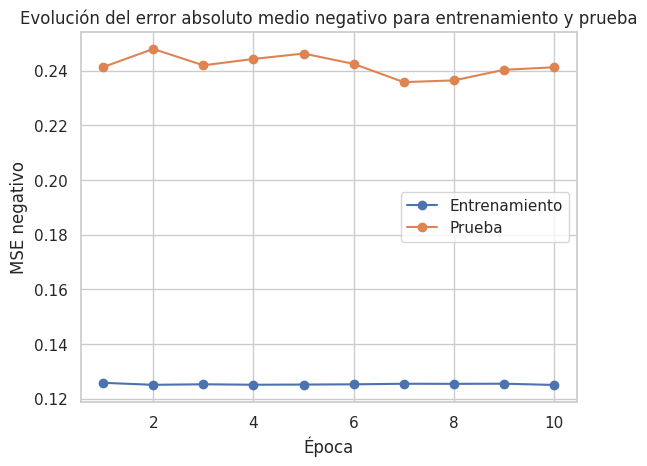

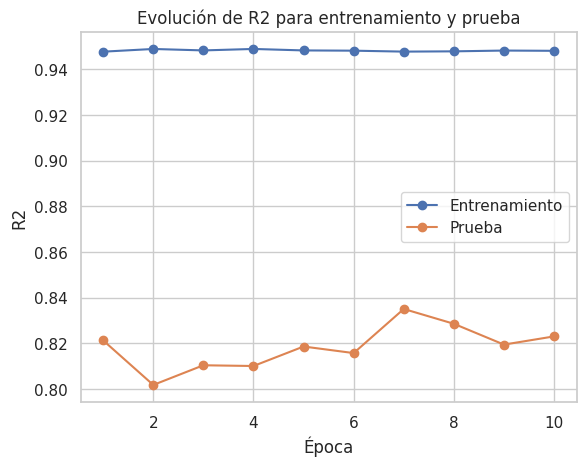

In [ ]:
#Hacemos el grafico de lo que hicimos
# Definir una lista con el número de épocas
epochs = list(range(1, 11))

# Graficar la evolución de MSE para entrenamiento y prueba
plt.plot(epochs, train_neg_mean_absolute_error, 'o-', label="Entrenamiento")
plt.plot(epochs, test_neg_mean_absolute_error, 'o-', label="Prueba")

# Etiquetas y título del gráfico
plt.xlabel("Época")
plt.ylabel("MSE negativo")
plt.title("Evolución del error absoluto medio negativo para entrenamiento y prueba")
plt.legend()

# Mostrar el gráfico
plt.show()

# Graficar la evolución de R2 para entrenamiento y prueba
plt.plot(epochs, train_r2, 'o-', label="Entrenamiento")
plt.plot(epochs, test_r2, 'o-', label="Prueba")

# Etiquetas y título del gráfico
plt.xlabel("Época")
plt.ylabel("R2")
plt.title("Evolución de R2 para entrenamiento y prueba")
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
# Convertir y_train a un array unidimensional
y_train = column_or_1d(y_train, warn=True)


param_grid = {'n_estimators': [50, 70, 200],
              'max_depth': [5, 10,15]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=184), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_rf.best_params_)
print("Mejor MSE promedio:", -grid_rf.best_score_)

Mejores hiperparámetros: {'max_depth': 15, 'n_estimators': 200}
Mejor MSE promedio: 0.19464600363872858


## Random forrest con los mejores hiperparametros

In [ ]:
#hallamos los parametros del mejor modelo (profundidad 15, estimadores 200)
best_rf = grid_rf.best_estimator_
best_rf

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=184)

In [ ]:
y_test_pred=best_rf.predict(X_test)
y_train_pred=best_rf.predict(X_train)

In [ ]:
# Calculamos las medidas para el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Calculamos las medidas para el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Creamos un DataFrame con las medidas
df = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MSE": [mse_train, mse_test],
    "MAE": [mae_train, mae_test],
    "R2": [r2_train, r2_test]
})

# Muestra el DataFrame
display(df)


,Conjunto,MSE,MAE,R2
0,Entrenamiento,0.109015,0.212932,0.891333
1,Prueba,0.180610,0.267930,0.817042
